## Library Imports

In [1]:
import os
import sys
import time
import argparse
import json



import cv2
import numpy as np
import torch.nn as nn
import torch.utils.data
from matplotlib import pyplot as plt
import matplotlib.patches as patches


from herbie_vision.model.centernet import get_hourglass, exkp

from herbie_vision.model.utils.utils import _tranpose_and_gather_feature, load_model
from herbie_vision.model.utils.image import transform_preds
from herbie_vision.model.utils.losses import _neg_loss, _reg_loss
from herbie_vision.model.utils.summary import create_summary, create_logger, create_saver, DisablePrint
from herbie_vision.model.utils.post_process import ctdet_decode

from google.api_core.protobuf_helpers import get_messages
from google.cloud import storage

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/Users/peterfagan/Desktop/gcp/waymo-2d-object-detection-514eeefdb0a3.json"

## Data Import

In [36]:
def download_blob(bucket_name, source_blob_name, destination_file_name):
    """Downloads a blob from the bucket."""
    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(source_blob_name)
    blob.download_to_filename(destination_file_name)
    
    print(
        "Blob {} downloaded to {}.".format(
            source_blob_name, destination_file_name
        )
    )
    
    

client = storage.Client()
bucket = client.get_bucket('waymo-processed')

download_blob('waymo-processed',
              'train/images/2019-05-14/10231929575853664160_1160_000_1180_000/10231929575853664160_1160_000_1180_000_0_FRONT.jpeg',
              '/Users/peterfagan/Code/Waymo-2D-Object-Detection/demo/example_1.jpeg')
download_blob('waymo-processed',
              'train/annotations/2019-05-14/10231929575853664160_1160_000_1180_000.json',
              '/Users/peterfagan/Code/Waymo-2D-Object-Detection/demo/annotations.json')

Blob train/images/2019-05-14/10231929575853664160_1160_000_1180_000/10231929575853664160_1160_000_1180_000_0_FRONT.jpeg downloaded to /Users/peterfagan/Code/Waymo-2D-Object-Detection/demo/example_1.jpeg.
Blob train/annotations/2019-05-14/10231929575853664160_1160_000_1180_000.json downloaded to /Users/peterfagan/Code/Waymo-2D-Object-Detection/demo/annotations.json.


## Examine Annotations

In [3]:
# Read in image annotations
f = open('/Users/peterfagan/Code/Waymo-2D-Object-Detection/demo/annotations.json','r')
annotations = json.load(f)
f.close()

# Annotations associated to the current image
for obj in annotations['annotations']:
    if obj['id']=='10793018113277660068_2714_540_2734_540_134':
        print(obj)
    else:
        continue

## Plot Bounding Boxes

NameError: name 'RGB_img' is not defined

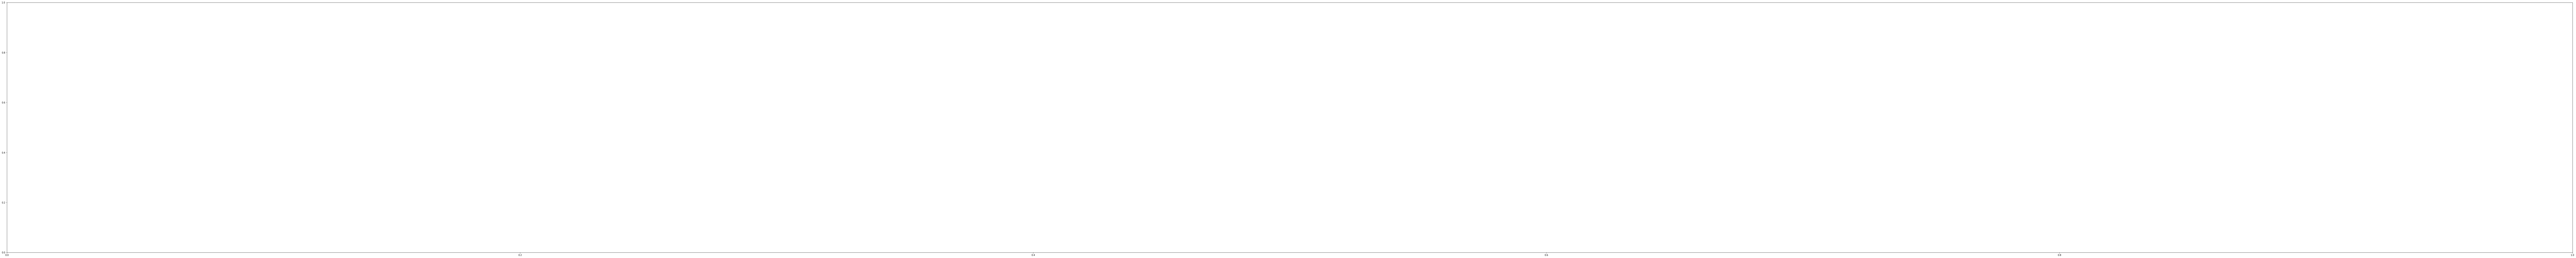

In [4]:
anns = [x for x in annotations['annotations'] if x['image_id']=='10231929575853664160_1160_000_1180_000_0_FRONT']

# Create figure and axes
fig, ax = plt.subplots(figsize = (200,20))

# Display the image
ax.imshow(RGB_img)

for entry in anns:
    h = entry['bbox'][3]
    w = entry['bbox'][2]
    x = entry['bbox'][0]
    y = entry['bbox'][1]
    
    # Create a Rectangle patch
    rect = patches.Rectangle((x,y), h, w, linewidth=2, edgecolor='r', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

plt.show()


## Model Playground

### Faster rcnn

In [8]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Initialize model and set to eval mode
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

# test some dummy inputs
inputs = torch.randn(3,1200,1200).unsqueeze(0)
print(model(inputs))

# test real image inputs
inputs = torch.tensor(img).permute(2,0,1).unsqueeze(0).float()
print(model(inputs))

/Users/peterfagan/.pyenv/versions/3.8.5/lib/python3.8/site-packages/torchvision/ops/boxes.py:101: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:766.)
  keep = keep.nonzero().squeeze(1)


[{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward>), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([], grad_fn=<IndexBackward>)}]
[{'boxes': tensor([[   0.,    0., 1920., 1280.]], grad_fn=<StackBackward>), 'labels': tensor([1]), 'scores': tensor([1.], grad_fn=<IndexBackward>)}]


### Centernet

In [2]:
# instantiate model
model = exkp(n=5, nstack=2, dims=[256, 256, 384, 384, 384, 512], modules=[2, 2, 2, 2, 2, 4],num_classes=3)
model.train()

    
inputs = torch.randn(1,3,512,512)
outputs = model(inputs)
hmap_tl, hmap_br, hmap_ct, embd_tl, embd_br, regs_tl, regs_br, regs_ct = zip(*outputs)

In [4]:
hmap_tl[0].shape

torch.Size([1, 3, 128, 128])

In [6]:
embd_tl[0].shape

torch.Size([1, 1, 128, 128])

In [7]:
regs_tl[0].shape

torch.Size([1, 2, 128, 128])